In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
df = pd.read_csv("clean.csv")
df.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMDBORN4,DMDEDUC2,INDFMPIR,DR1TKCAL,DR1TPROT,DR1TCARB,...,PAQ665,RXDUSE,RXDDRUG,RXDDRGID,RXDRSC1,BPQ020,DIQ010,DBQ700,DBQ197,HIQ011
0,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,ATORVASTATIN,d04105,E78.0,1.0,1.0,3.0,2.0,1.0
1,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,EMPAGLIFLOZIN,d08275,R73,1.0,1.0,3.0,2.0,1.0
2,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,METFORMIN,d03807,R73,1.0,1.0,3.0,2.0,1.0
3,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,METOPROLOL,d00134,I10,1.0,1.0,3.0,2.0,1.0
4,109300.0,2.0,54.0,6.0,2.0,5.0,5.0,719.0,27.71,86.45,...,2.0,2.0,NONE,NONE,NONE,2.0,2.0,2.0,2.0,1.0


In [3]:
df.columns

Index(['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2',
       'INDFMPIR', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE',
       'DR1TTFAT', 'DR1TSFAT', 'DR1TCHOL', 'DR1TALCO', 'DR1TCAFF', 'DR1TSODI',
       'DR1TPOTA', 'DR2TKCAL', 'DR2TPROT', 'DR2TCARB', 'DR2TSUGR', 'DR2TFIBE',
       'DR2TTFAT', 'DR2TSFAT', 'DR2TCHOL', 'DR2TALCO', 'DR2TCAFF', 'DR2TSODI',
       'DR2TPOTA', 'BPXOSY1', 'BPXODI1', 'BPXOSY2', 'BPXODI2', 'BPXOSY3',
       'BPXODI3', 'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3', 'BMXWT', 'BMXHT',
       'BMXBMI', 'BMXWAIST', 'LBXIN', 'LBXGLU', 'LBXTR', 'LBDLDL', 'LBDHDD',
       'LBXHSCRP', 'PHAFSTHR', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650',
       'PAQ665', 'RXDUSE', 'RXDDRUG', 'RXDDRGID', 'RXDRSC1', 'BPQ020',
       'DIQ010', 'DBQ700', 'DBQ197', 'HIQ011'],
      dtype='object')

In [4]:
columns_to_drop = [
    # Day 1 dietary variables
    'DR1TPROT', 'DR1TCARB', 'DR1TCHOL', 'DR1TALCO',
    'DR1TCAFF', 'DR1TSODI', 'DR1TPOTA',
    
    # Day 2 dietary variables
    'DR2TPROT', 'DR2TCARB', 'DR2TCHOL', 'DR2TALCO', 
    'DR2TCAFF', 'DR2TSODI', 'DR2TPOTA',
    
    # Weight and height
    'BMXWT', 'BMXHT',

    # Blood pressure pulse readings
    'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3',

    # Drug metadata
    'RXDDRGID', 'RXDRSC1',

    'SEQN', 'LBDLDL', 'RIDAGEYR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2', 'PHAFSTHR',
    'PAQ665', 'BPQ020', 'DIQ010', 'HIQ011'
]
df.drop(columns=columns_to_drop, inplace=True)

# Feature Engineering
### Clinical Risk Indicators (Metabolic Syndrome Flags)

In [5]:
# Obesity based on waist circumference (gender-specific)
df['flag_obese'] = ((df['RIAGENDR'] == 1) & (df['BMXWAIST'] > 102)) | \
                   ((df['RIAGENDR'] == 2) & (df['BMXWAIST'] > 88))

# Elevated blood pressure
df['avg_sys'] = df[['BPXOSY1', 'BPXOSY2', 'BPXOSY3']].mean(axis=1)
df['avg_dia'] = df[['BPXODI1', 'BPXODI2', 'BPXODI3']].mean(axis=1)
df['flag_high_bp'] = (df['avg_sys'] >= 130) | (df['avg_dia'] >= 85)

# Elevated fasting glucose
df['flag_high_glucose'] = df['LBXGLU'] >= 100

# Elevated triglycerides
df['flag_high_triglycerides'] = df['LBXTR'] >= 150

# Low HDL cholesterol (gender-specific)
df['flag_low_hdl'] = ((df['RIAGENDR'] == 1) & (df['LBDHDD'] < 40)) | \
                     ((df['RIAGENDR'] == 2) & (df['LBDHDD'] < 50))

# HOMA-IR
df['HOMA_IR'] = (df['LBXIN'] * df['LBXGLU']) / 405
df['flag_homa_ir'] = df['HOMA_IR'] > 2.5  

### Derived Metabolic Syndrome Target

In [6]:
df['met_syndrome_count'] = df[['flag_obese', 'flag_high_bp', 'flag_high_glucose',
                               'flag_high_triglycerides', 'flag_low_hdl', 'flag_homa_ir']].sum(axis=1)
df['has_metabolic_syndrome'] = df['met_syndrome_count'] >= 3

### Lifestyle Feature Engineering

In [7]:
# Average Daily Intake
df['avg_kcal'] = df[['DR1TKCAL', 'DR2TKCAL']].mean(axis=1)
df['avg_sugar'] = df[['DR1TSUGR', 'DR2TSUGR']].mean(axis=1)
df['avg_fat'] = df[['DR1TTFAT', 'DR2TTFAT']].mean(axis=1)
df['avg_fiber'] = df[['DR1TFIBE', 'DR2TFIBE']].mean(axis=1)

# Change in Intake
df['delta_kcal'] = df['DR2TKCAL'] - df['DR1TKCAL']
df['delta_sugar'] = df['DR2TSUGR'] - df['DR1TSUGR']
df['delta_fat'] = df['DR2TTFAT'] - df['DR1TTFAT']

# Binary Flags for Intake Reduction
df['reduced_calories'] = df['delta_kcal'] < -100
df['reduced_sugar'] = df['delta_sugar'] < -10

# Likely Dieting (Overweight + trying to lose weight + reduced intake)
df['likely_dieting'] = (
    (df['BMXBMI'] >= 25) &
    df['reduced_calories'] &
    df['DBQ700'].eq(1)
)

# Eating Out Behavior
df['eats_out_often'] = df['DBQ197'].isin([1, 2])  # every day / most days
df['eats_out_rarely'] = df['DBQ197'].isin([4, 5])  # 1–2x/week or never

# Physical Activity
df['physically_active'] = (
    df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].isin([1]).any(axis=1)
)
df['activity_score'] = df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)

# Lifestyle Effort Score
df['lifestyle_effort'] = (
    df['likely_dieting'].astype(int)
    + df['eats_out_rarely'].astype(int)
    + df['delta_kcal'].apply(lambda x: 1 if x < 0 else 0)  # decreased calories
    + df['delta_sugar'].apply(lambda x: 1 if x < 0 else 0)  # decreased sugar
    + df['physically_active'].astype(int)  # NEW: physical activity
)

/var/folders/z1/w_njtpr52ss65yn2_5wp9xfm0000gn/T/ipykernel_49326/814351403.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df['activity_score'] = df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)


### Med_Class Variable

In [8]:
met_syn_drugs = [
    # Diabetes-related
    'METFORMIN', 'INSULIN', 'GLIPIZIDE', 'GLYBURIDE', 'PIOGLITAZONE', 'SITAGLIPTIN',
    'EMPAGLIFLOZIN', 'DAPAGLIFLOZIN', 'CANAGLIFLOZIN', 'LINAGLIPTIN', 'LIRAGLUTIDE',
    'EXENATIDE', 'SEMAGLUTIDE', 'GLIMEPIRIDE',

    # Hypertension
    'LISINOPRIL', 'LOSARTAN', 'AMLODIPINE', 'METOPROLOL', 'RAMIPRIL', 'FUROSEMIDE',
    'HYDROCHLOROTHIAZIDE', 'VALSARTAN', 'BISOPROLOL', 'SPIRONOLACTONE', 'DILTIAZEM',

    # Cholesterol
    'ATORVASTATIN', 'ROSUVASTATIN', 'SIMVASTATIN', 'PRAVASTATIN', 'PITAVASTATIN',
    'EZETIMIBE', 'FENOFIBRATE', 'GEMFIBROZIL', 'FENOFIBRIC ACID', 'NIACIN',
]

# Clean and classify each record
def classify_meds(drug_str):
    if pd.isna(drug_str) or drug_str.strip().upper() in ['NONE', 'NO MEDICATION', '']:
        return 'None'

    # Clean and split into list
    drugs = [d.strip().upper() for d in drug_str.split(';')]
    
    has_met_syn = any(any(med in drug for med in met_syn_drugs) for drug in drugs)
    has_non_met_syn = any(not any(med in drug for med in met_syn_drugs) for drug in drugs)

    if has_met_syn and has_non_met_syn:
        return 'Both MetSyn + Other'
    elif has_met_syn:
        return 'MetSyn-related'
    elif has_non_met_syn:
        return 'Other'
    else:
        return 'None'

# Apply to your column
df['med_class'] = df['RXDDRUG'].astype(str).apply(classify_meds)

In [9]:
# 1 corresponds to using medication
# 2 corresponds to not using medication

### Income_Level Variable

In [10]:
df['income_level'] = pd.cut(df['INDFMPIR'],
                            bins=[-0.1, 1.3, 3.5, df['INDFMPIR'].max()],
                            labels=['Low Income', 'Middle Income', 'High Income'])
df['likely_dieting_numeric'] = df['likely_dieting'].astype(int)

In [11]:
df.columns

Index(['RIAGENDR', 'INDFMPIR', 'DR1TKCAL', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT',
       'DR1TSFAT', 'DR2TKCAL', 'DR2TSUGR', 'DR2TFIBE', 'DR2TTFAT', 'DR2TSFAT',
       'BPXOSY1', 'BPXODI1', 'BPXOSY2', 'BPXODI2', 'BPXOSY3', 'BPXODI3',
       'BMXBMI', 'BMXWAIST', 'LBXIN', 'LBXGLU', 'LBXTR', 'LBDHDD', 'LBXHSCRP',
       'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'RXDUSE', 'RXDDRUG', 'DBQ700',
       'DBQ197', 'flag_obese', 'avg_sys', 'avg_dia', 'flag_high_bp',
       'flag_high_glucose', 'flag_high_triglycerides', 'flag_low_hdl',
       'HOMA_IR', 'flag_homa_ir', 'met_syndrome_count',
       'has_metabolic_syndrome', 'avg_kcal', 'avg_sugar', 'avg_fat',
       'avg_fiber', 'delta_kcal', 'delta_sugar', 'delta_fat',
       'reduced_calories', 'reduced_sugar', 'likely_dieting', 'eats_out_often',
       'eats_out_rarely', 'physically_active', 'activity_score',
       'lifestyle_effort', 'med_class', 'income_level',
       'likely_dieting_numeric'],
      dtype='object')

In [12]:
df.dtypes[df.dtypes == 'object']

RXDDRUG      object
med_class    object
dtype: object

In [13]:
df.dtypes[df.dtypes == 'category']

income_level    category
dtype: object

In [14]:
df.dtypes[df.dtypes == 'int64']

met_syndrome_count        int64
activity_score            int64
lifestyle_effort          int64
likely_dieting_numeric    int64
dtype: object

In [15]:
df.dtypes[df.dtypes == 'float64']

RIAGENDR       float64
INDFMPIR       float64
DR1TKCAL       float64
DR1TSUGR       float64
DR1TFIBE       float64
DR1TTFAT       float64
DR1TSFAT       float64
DR2TKCAL       float64
DR2TSUGR       float64
DR2TFIBE       float64
DR2TTFAT       float64
DR2TSFAT       float64
BPXOSY1        float64
BPXODI1        float64
BPXOSY2        float64
BPXODI2        float64
BPXOSY3        float64
BPXODI3        float64
BMXBMI         float64
BMXWAIST       float64
LBXIN          float64
LBXGLU         float64
LBXTR          float64
LBDHDD         float64
LBXHSCRP       float64
PAQ605         float64
PAQ620         float64
PAQ635         float64
PAQ650         float64
RXDUSE         float64
DBQ700         float64
DBQ197         float64
avg_sys        float64
avg_dia        float64
HOMA_IR        float64
avg_kcal       float64
avg_sugar      float64
avg_fat        float64
avg_fiber      float64
delta_kcal     float64
delta_sugar    float64
delta_fat      float64
dtype: object

In [16]:
predictors_lifestyle = [
    # Lifestyle and Behavior
    'avg_kcal', 'avg_sugar', 'avg_fat', 'avg_fiber',
    'reduced_calories', 'reduced_sugar', 'likely_dieting',
    'eats_out_often', 'eats_out_rarely',
    'physically_active', 'lifestyle_effort',

    # Income
    'income_level'
]

predictors_with_meds = predictors_lifestyle + ['med_class']

In [17]:
df['has_metabolic_syndrome'].value_counts()

has_metabolic_syndrome
True     3941
False    2219
Name: count, dtype: int64

In [18]:
df[predictors_lifestyle]

,avg_kcal,avg_sugar,avg_fat,avg_fiber,reduced_calories,reduced_sugar,likely_dieting,eats_out_often,eats_out_rarely,physically_active,lifestyle_effort,income_level
0,1333.0,54.360,53.120,10.30,False,False,False,True,False,True,1,High Income
1,1333.0,54.360,53.120,10.30,False,False,False,True,False,True,1,High Income
2,1333.0,54.360,53.120,10.30,False,False,False,True,False,True,1,High Income
3,1333.0,54.360,53.120,10.30,False,False,False,True,False,True,1,High Income
4,784.5,31.170,40.805,6.65,False,False,False,True,False,False,0,High Income
...,...,...,...,...,...,...,...,...,...,...,...,...
6155,1972.0,70.765,91.960,12.55,True,True,False,True,False,False,2,High Income
6156,1972.0,70.765,91.960,12.55,True,True,False,True,False,False,2,High Income
6157,1972.0,70.765,91.960,12.55,True,True,False,True,False,False,2,High Income
6158,1783.5,136.995,60.405,8.45,False,False,False,False,False,True,1,Middle Income


In [19]:
df_subset = df[predictors_with_meds + ['has_metabolic_syndrome']]
df_subset.head()

,avg_kcal,avg_sugar,avg_fat,avg_fiber,reduced_calories,reduced_sugar,likely_dieting,eats_out_often,eats_out_rarely,physically_active,lifestyle_effort,income_level,med_class,has_metabolic_syndrome
0,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,High Income,MetSyn-related,True
1,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,High Income,MetSyn-related,True
2,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,High Income,MetSyn-related,True
3,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,High Income,MetSyn-related,True
4,784.5,31.17,40.805,6.65,False,False,False,True,False,False,0,High Income,None,True


In [20]:
df['income_level'].value_counts()

income_level
Middle Income    2480
High Income      2013
Low Income       1667
Name: count, dtype: int64

In [21]:
# variables that need categorical encoding:
# reduced_calories, reduced_sugar, likely_dieting, eats_out_often, eats_out_rarely, physically_active
# income_level, med_class, has_metabolic
income_mapping = {
    'Low Income': 0,
    'Middle Income': 1,
    'High Income': 2
}
df_encoded = pd.get_dummies(df_subset, columns=['med_class'], drop_first=True)
df_encoded['income_level'] = df['income_level'].map(income_mapping).astype(int)
df_encoded.head()

,avg_kcal,avg_sugar,avg_fat,avg_fiber,reduced_calories,reduced_sugar,likely_dieting,eats_out_often,eats_out_rarely,physically_active,lifestyle_effort,income_level,has_metabolic_syndrome,med_class_MetSyn-related,med_class_None,med_class_Other
0,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,2,True,True,False,False
1,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,2,True,True,False,False
2,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,2,True,True,False,False
3,1333.0,54.36,53.120,10.30,False,False,False,True,False,True,1,2,True,True,False,False
4,784.5,31.17,40.805,6.65,False,False,False,True,False,False,0,2,True,False,True,False


In [22]:
df_encoded.isnull().sum()

avg_kcal                    0
avg_sugar                   0
avg_fat                     0
avg_fiber                   0
reduced_calories            0
reduced_sugar               0
likely_dieting              0
eats_out_often              0
eats_out_rarely             0
physically_active           0
lifestyle_effort            0
income_level                0
has_metabolic_syndrome      0
med_class_MetSyn-related    0
med_class_None              0
med_class_Other             0
dtype: int64

In [23]:
df_encoded.columns.tolist()

['avg_kcal',
 'avg_sugar',
 'avg_fat',
 'avg_fiber',
 'reduced_calories',
 'reduced_sugar',
 'likely_dieting',
 'eats_out_often',
 'eats_out_rarely',
 'physically_active',
 'lifestyle_effort',
 'income_level',
 'has_metabolic_syndrome',
 'med_class_MetSyn-related',
 'med_class_None',
 'med_class_Other']

In [24]:
all_columns = df_encoded.columns.tolist()
med_class_columns = all_columns[-3:]
predictors_lifestyle_only = all_columns[0:12]
predictors_with_meds = predictors_lifestyle_only + med_class_columns
numeric_cols = ['avg_kcal', 'avg_sugar', 'avg_fat', 'avg_fiber']

In [25]:
from sklearn.feature_selection import VarianceThreshold

def prepare_data(df, predictors, scale=True):
    X = df[predictors]    
    y = df['has_metabolic_syndrome'].astype(int)

    # Train/Test Split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Remove zero-variance columns 
    vt = VarianceThreshold(threshold=0.0)
    X_train = pd.DataFrame(vt.fit_transform(X_train), columns=X_train.columns[vt.get_support()])
    X_test = X_test[X_train.columns]  # Keep only the columns from X_train in X_test

    if scale:
        scaler = StandardScaler()
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    else:
        scaler = None

    # SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test

In [26]:
# Model A: Lifestyle + Medications
X_train_A, X_test_A, y_train_A, y_test_A = prepare_data(df_encoded, predictors_with_meds)

# Model B: Lifestyele Only
X_train_B, X_test_B, y_train_B, y_test_B = prepare_data(df_encoded, predictors_lifestyle_only)

In [27]:
# Define models and parameter grids
model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ['l2'],  # 'l1' requires solver='liblinear'
            "solver": ['lbfgs']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['rbf', 'linear']
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (100, 50)],
            "activation": ['relu', 'tanh'],
            "alpha": [0.0001, 0.001],
        }
    }
}


In [28]:
def train_and_tune_models(X_train, y_train, X_test, y_test):
    results = {}

    for name, mp in model_params.items():
        print(f"\n🔍 Training {name}...")
        model = mp["model"]
        param_grid = mp["params"]

        grid = GridSearchCV(
            model,
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='f1',
            n_jobs=-1
        )

        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        print("✅ Best Parameters:", grid.best_params_)
        print("📊 Classification Report:\n", classification_report(y_test, y_pred))
        if y_prob is not None:
            print("🔵 ROC AUC Score:", roc_auc_score(y_test, y_prob))

        # Store results
        results[name] = {
            "model": best_model,
            "best_params": grid.best_params_,
            "y_pred": y_pred,
            "y_prob": y_prob,
            "report": classification_report(y_test, y_pred, output_dict=True),
            "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        }

    return results

In [29]:
# Model A: Lifestyle + Meds
print("\n==============================")
print("🚀 MODEL A: Lifestyle + Medications")
print("==============================")
results_A = train_and_tune_models(X_train_A, y_train_A, X_test_A, y_test_A)

# Model B: Lifestyle Only
print("\n==============================")
print("🚀 MODEL B: Lifestyle Only")
print("==============================")
results_B = train_and_tune_models(X_train_B, y_train_B, X_test_B, y_test_B)


🚀 MODEL A: Lifestyle + Medications

🔍 Training Logistic Regression...
✅ Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.55      0.51       666
           1       0.72      0.66      0.69      1182

    accuracy                           0.62      1848
   macro avg       0.60      0.61      0.60      1848
weighted avg       0.63      0.62      0.63      1848

🔵 ROC AUC Score: 0.6498503579721853

🔍 Training Random Forest...
✅ Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       666
           1       0.89      0.90      0.90      1182

    accuracy                           0.87      1848
   macro avg       0.85      0.85      0.85      1848
weighted avg       0.86      0.87      0.86      1848

🔵 ROC AUC S

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

✅ Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       666
           1       0.92      0.92      0.92      1182

    accuracy                           0.90      1848
   macro avg       0.89      0.89      0.89      1848
weighted avg       0.90      0.90      0.90      1848

🔵 ROC AUC Score: 0.9590643943435823

🔍 Training SVM...
✅ Best Parameters: {'C': 10, 'kernel': 'rbf'}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65       666
           1       0.81      0.79      0.80      1182

    accuracy                           0.75      1848
   macro avg       0.72      0.73      0.73      1848
weighted avg       0.75      0.75      0.75      1848

🔵 ROC AUC Score: 0.7925323800958319

🔍 Training MLP...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

✅ Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       666
           1       0.90      0.91      0.90      1182

    accuracy                           0.88      1848
   macro avg       0.87      0.86      0.86      1848
weighted avg       0.87      0.88      0.87      1848

🔵 ROC AUC Score: 0.9097384186216674

🚀 MODEL B: Lifestyle Only

🔍 Training Logistic Regression...
✅ Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.53      0.47       666
           1       0.69      0.59      0.64      1182

    accuracy                           0.57      1848
   macro avg       0.56      0.56      0.56      1848
weighted avg       0.60      0.57      0.58      1848

🔵 ROC AUC Score: 0.6025352763931444

🔍 

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

✅ Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       666
           1       0.91      0.92      0.91      1182

    accuracy                           0.89      1848
   macro avg       0.88      0.88      0.88      1848
weighted avg       0.89      0.89      0.89      1848

🔵 ROC AUC Score: 0.9566901927308019

🔍 Training SVM...
✅ Best Parameters: {'C': 10, 'kernel': 'rbf'}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.64       666
           1       0.80      0.77      0.78      1182

    accuracy                           0.73      1848
   macro avg       0.71      0.71      0.71      1848
weighted avg       0.73      0.73      0.73      1848

🔵 ROC AUC Score: 0.7659918802050782

🔍 Training MLP...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

✅ Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       666
           1       0.91      0.93      0.92      1182

    accuracy                           0.90      1848
   macro avg       0.89      0.88      0.89      1848
weighted avg       0.89      0.90      0.90      1848

🔵 ROC AUC Score: 0.9036104632551333


In [30]:
# extract and plot feature importances

In [40]:
def plot_shap_bar(model, X_test, title, save_path=None):
    explainer = shap.TreeExplainer(model)
    X_for_shap = X_test[model.feature_names_in_]
    shap_values = explainer.shap_values(X_for_shap)

    if isinstance(shap_values, list):  
        shap_values_class1 = shap_values[1]
    elif shap_values.ndim == 3:  
        shap_values_class1 = shap_values[:, :, 1]
    else:  
        shap_values_class1 = shap_values

    plt.figure()
    shap.summary_plot(shap_values_class1, X_for_shap, plot_type="bar", show=False)
    plt.title(title)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

Saved: shap_plots/groupA_rf.png


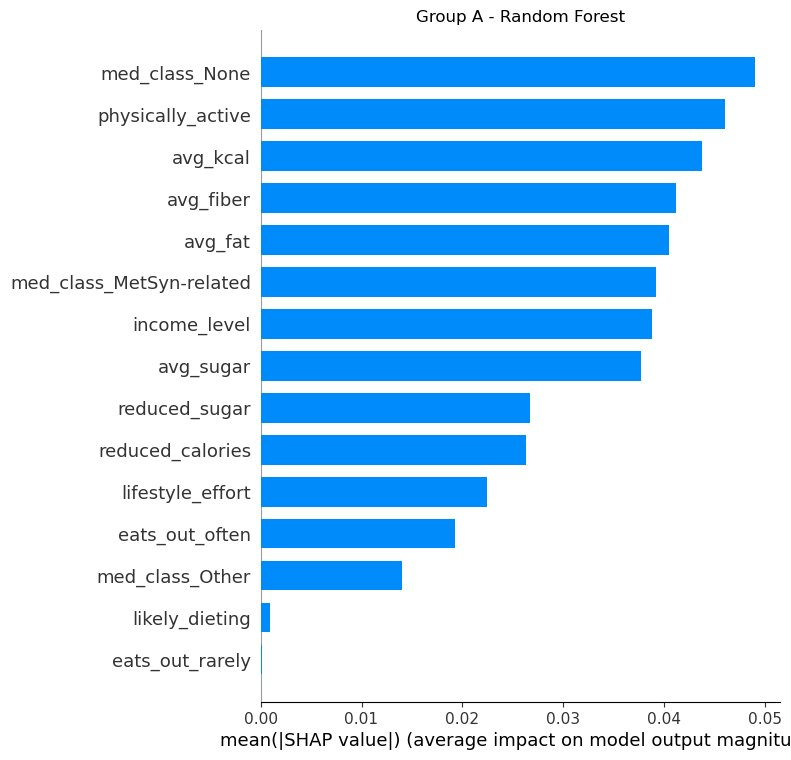

Saved: shap_plots/groupA_xgb.png


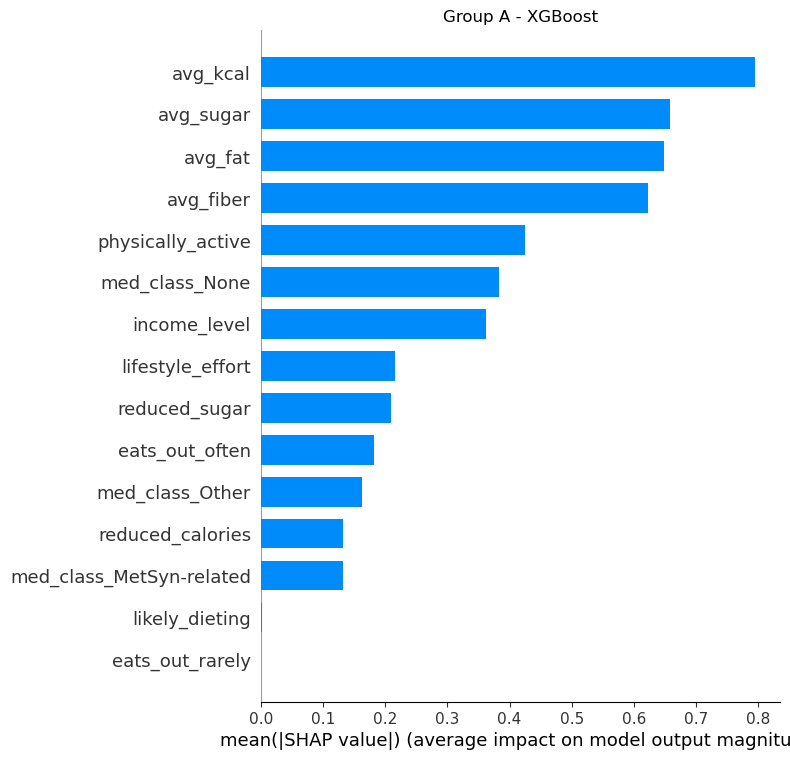

Saved: shap_plots/groupB_rf.png


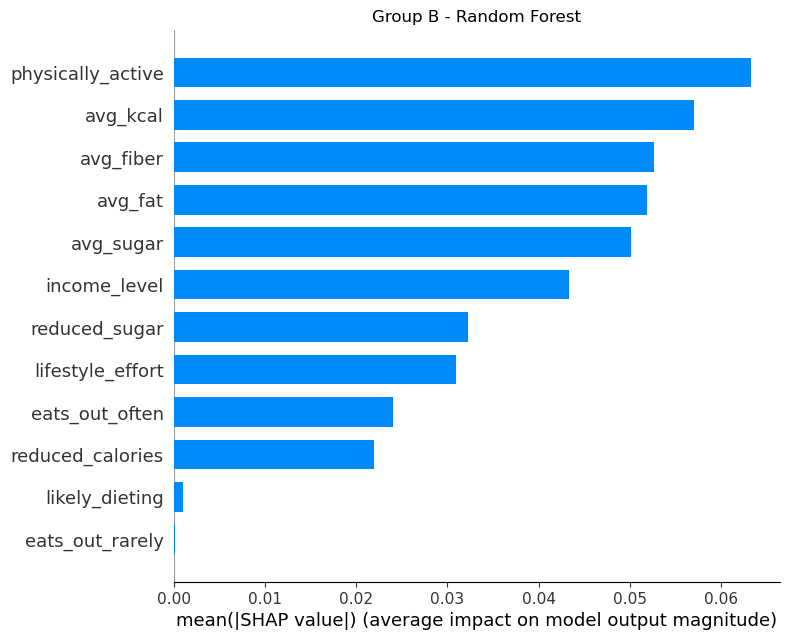

Saved: shap_plots/groupB_xgb.png


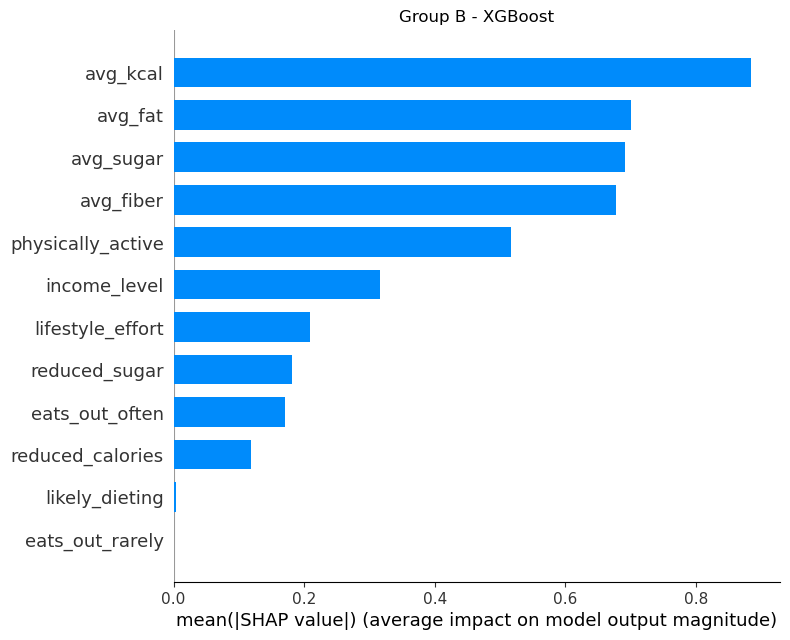

In [43]:
plot_shap_bar(results_A["Random Forest"]["model"], X_test_A, "Group A - Random Forest", "shap_plots/groupA_rf.png")
plot_shap_bar(results_A["XGBoost"]["model"], X_test_A, "Group A - XGBoost", "shap_plots/groupA_xgb.png")
plot_shap_bar(results_B["Random Forest"]["model"], X_test_B, "Group B - Random Forest", "shap_plots/groupB_rf.png")
plot_shap_bar(results_B["XGBoost"]["model"], X_test_B, "Group B - XGBoost", "shap_plots/groupB_xgb.png")